In [85]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import PIL
import torchvision.transforms

In [3]:
# check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# load training data
train_data = datasets.MNIST(
    root = 'data',
    train = True, 
    transform = ToTensor(),
    download = True
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw




Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw




Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Processing...


C:\Users\hungt\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


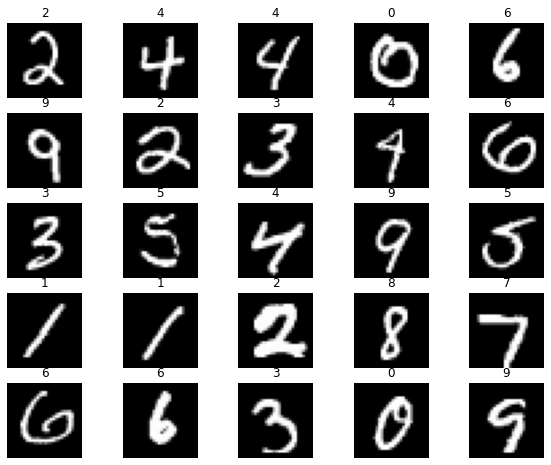

In [15]:
# show example data
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [20]:
# create minibatches (like for stochastic gradient descent)
# which are reshuffled at every epoch to reduce model overfitting
# python multiprocessing speeds up data retrieval
loaders = {
    'train' : torch.utils.data.DataLoader(
        train_data, # training data
        batch_size=100, # minibatch size
        shuffle=True, # shuffle after each epoch
        num_workers=1
    ),
    'test' : torch.utils.data.DataLoader(
        test_data,
        batch_size=100,
        shuffle=True,
        num_workers=1
    )
}

In [41]:
# Define Neural Network model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, # num of channels for input image
                out_channels=16, # num of channels produced by conv1
                kernel_size=5, # size of convolving kernel
                stride=1, # Stride of convolution
                padding=2, # zero-padding added to both sides of input
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # flatten output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x # x is for visualization

In [42]:
# instantiate CNN
cnn = CNN()

In [43]:
# define loss function
loss_func = nn.CrossEntropyLoss()

In [44]:
# define optimizer
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

In [45]:
# Train the model
def train(num_epochs, cnn, loaders):
    cnn.train()
    
    # train model
    total_step = len(loaders['train']) # num of training examples
    
    # loop through however many epochs
    for epoch in range(num_epochs):
        
        #loop through each training example
        for i, (images, labels) in enumerate(loaders['train']):
            
            b_x = Variable(images)
            b_y = Variable(labels)
            
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)
            
            optimizer.zero_grad() # clear gradient from previous loop
            loss.backward() # backprop to get gradient
            optimizer.step() # apply gradient
            
            # print stats every 100 steps
            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch + 1, 
                    num_epochs, 
                    i + 1, 
                    total_step, 
                    loss.item()
                ))
                pass
        pass
    pass

In [46]:
num_epochs = 10
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.3015
Epoch [1/10], Step [200/600], Loss: 0.0667
Epoch [1/10], Step [300/600], Loss: 0.0750
Epoch [1/10], Step [400/600], Loss: 0.0545
Epoch [1/10], Step [500/600], Loss: 0.0581
Epoch [1/10], Step [600/600], Loss: 0.1587
Epoch [2/10], Step [100/600], Loss: 0.0341
Epoch [2/10], Step [200/600], Loss: 0.0239
Epoch [2/10], Step [300/600], Loss: 0.0148
Epoch [2/10], Step [400/600], Loss: 0.1027
Epoch [2/10], Step [500/600], Loss: 0.0293
Epoch [2/10], Step [600/600], Loss: 0.0729
Epoch [3/10], Step [100/600], Loss: 0.1729
Epoch [3/10], Step [200/600], Loss: 0.1134
Epoch [3/10], Step [300/600], Loss: 0.0468
Epoch [3/10], Step [400/600], Loss: 0.0180
Epoch [3/10], Step [500/600], Loss: 0.1420
Epoch [3/10], Step [600/600], Loss: 0.0119
Epoch [4/10], Step [100/600], Loss: 0.1064
Epoch [4/10], Step [200/600], Loss: 0.0091
Epoch [4/10], Step [300/600], Loss: 0.0435
Epoch [4/10], Step [400/600], Loss: 0.0637
Epoch [4/10], Step [500/600], Loss: 0.1026
Epoch [4/10

In [50]:
# test the model
def test():
    cnn.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print(f'Test Accuracy of the model on the 10000 test images: {accuracy * 100}%')
    pass

test()

Test Accuracy of the model on the 10000 test images: 97.0%


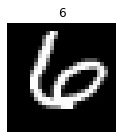

CNN prediction of image: 6


In [80]:
# test specific number
sample = next(iter(loaders['test']))
imgs, labels = sample

img = imgs[:1]
label = labels[0].numpy()

# plot image and label
figure = plt.figure(figsize=(2, 2))

plt.imshow(img.squeeze(), cmap="gray")
plt.title(label)
plt.axis('off')

plt.show()

# put image into neural network
test_output, last_layer = cnn(img)
pred = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'CNN prediction of image: {pred}')

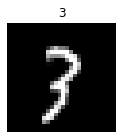

CNN prediction of image: 3


In [127]:
# test specific number
img_ind = 8012
img, label = train_data[img_ind]

# plot image and label
figure = plt.figure(figsize=(2, 2))

plt.imshow(img.squeeze(), cmap="gray")
plt.title(label)
plt.axis('off')

plt.show()

# put image into neural network
test_output, last_layer = cnn(img.unsqueeze(0))
pred = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'CNN prediction of image: {pred}')